# Attribute Genration II

Las coordenadas que tenemos nos ofrecen información importante, no es lo mismo moverse en el centro de montevideo que en las afueras, los diferentes tamaños de las vias, cantidad de personas en circulación o que usan el omnibus como medio de transporte varia dependiendo de la ubicación. Trabajar con estas coordenadas en un futuro va a resultar en problemas complejos por lo cual requerimos de algun metodo para mantener la información pero tenerla en un formato mas simple. Para esto vamos a segmentar a Montevideo en una matriz de ubicaciones en las cual ubicaremos los segmentos de recorridos. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
data = pd.read_csv('../data/bus_data_stage_2.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed
0,76,217,-56.222400,-34.855885,2018-10-02 14:38:53,-56.222717,-34.855766,2018-10-02 14:39:23,31.807877,0 days 00:00:30.000000000,1.060263
1,76,217,-56.222717,-34.855766,2018-10-02 14:39:23,-56.222733,-34.855780,2018-10-02 14:39:53,2.134200,0 days 00:00:30.000000000,0.071140
2,76,217,-56.222733,-34.855780,2018-10-02 14:39:53,-56.222916,-34.855682,2018-10-02 14:40:08,19.939152,0 days 00:00:15.000000000,1.329277
3,76,217,-56.222916,-34.855682,2018-10-02 14:40:08,-56.222866,-34.855682,2018-10-02 14:40:23,4.562295,0 days 00:00:15.000000000,0.304153
4,76,217,-56.222866,-34.855682,2018-10-02 14:40:23,-56.222850,-34.855667,2018-10-02 14:40:38,2.216614,0 days 00:00:15.000000000,0.147774


Ahora vamos a crear una bounding box que contiene a todos los recorridos

In [3]:
MAX_LAT = data.latitude.max()
MAX_LON = data.longitude.max()
MIN_LAT = data.latitude.min()
MIN_LON = data.longitude.min()
print('Max Latitude: {1}\nMax Longitude: {1}\nMin Latitude: {2}\nMin Longitude: {3}\n'.format(MAX_LAT,
                                                                                              MAX_LON,
                                                                                              MIN_LAT,
                                                                                              MIN_LON))

Max Latitude: -55.99586
Max Longitude: -55.99586
Min Latitude: -34.928585
Min Longitude: -56.256016



Ahora creamos una bounding box con un padding de 0.001 _(100m)_ y sectores de 0.01 _(1Km)_.

In [4]:
step = 0.01
padding = 0.001
longitude = np.arange(MIN_LON+padding, MAX_LON+padding, step)
latitude  = np.arange(MIN_LAT+padding, MAX_LAT+padding, step)
print('Matrix ({0}x{1})'.format(len(latitude),len(longitude)))
matrix = pd.DataFrame(columns=['latitude','longitude'])
points_lat = []
points_lon = []
for lon in latitude:
    for lat in longitude:
        points_lat.append(lat)
        points_lon.append(lon)
matrix.latitude  = points_lat
matrix.longitude = points_lon

Matrix (22x27)


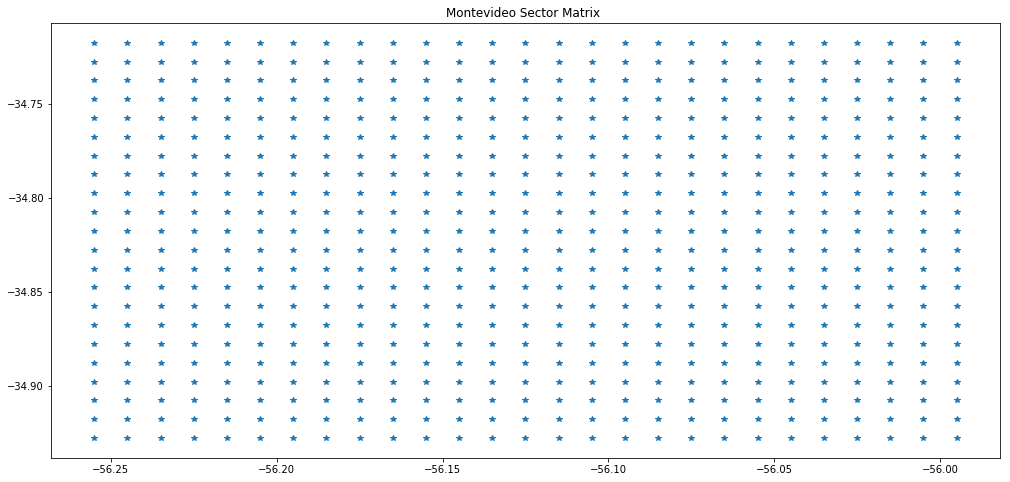

In [5]:
plt.figure(figsize=(17,8))
plt.title('Montevideo Sector Matrix ')
plt.plot(matrix.latitude, matrix.longitude,'*')

In [6]:
matrix.head()

,latitude,longitude
0,-56.255016,-34.927585
1,-56.245016,-34.927585
2,-56.235016,-34.927585
3,-56.225016,-34.927585
4,-56.215016,-34.927585


In [7]:
def print_base():
    plt.figure(figsize=(17,8))
    plt.plot(matrix.latitude, matrix.longitude,'o', c='b')
    
def print_section(position, section):
    plt.text(position[1]+0.002,position[0]-0.006, '({0},{1})'.format(str(section[0]),
                                                                     str(section[1])),
                                                                     fontsize=9, color='k')
    plt.plot(position[1]+0.005,position[0]-0.005,'s',c='r', markersize= 20)

def get_position_in_matrix(orig_lat, orig_long, dest_lat, dest_long, step = 0.01, padding = 0.001):
    longitude = np.arange(MIN_LON + padding, MAX_LON + padding, step)
    latitude  = np.arange(MIN_LAT + padding, MAX_LAT + padding, step)
    centroid_lat = orig_lat  + abs(orig_lat  - dest_lat) /2
    centroid_lon = orig_long + abs(orig_long - dest_long)/2
    position = [None, None]
    section  = [None, None]
    for index, lat in enumerate(latitude):
        if lat >= centroid_lat:
            position[0] = lat
            section[0]  = index
            break
    for index, lon in enumerate(longitude):
        if lon >= centroid_lon:
            position[1] = lon
            section[1]  = index
            break
    return section

def show_matrix(line, r=22,c=27, show_speed=False):
    positions, speeds = get_matrix_positions(line)
    matrix = np.zeros((r,c))
    fig, ax = plt.subplots()
    plt.title(str(line.line.iloc[0])+' '+str(line.id.iloc[0]))
    for index, point in enumerate(positions):
        matrix[point[0]][point[1]] = speeds[index]
        if show_speed:
            _ = round(speeds[index],0)
        else:
            _ = str('{0},{1}'.format(str(point[0]),str(point[1])))
        ax.text(point[1], point[0], _, ha="center", va="center", color="w")

    ax.imshow(matrix, origin='lower')
    plt.show()
    return positions

def get_matrix_positions(line):
    positions = []
    speeds    = []
    for row in line.itertuples():
        position = get_position_in_matrix(row.latitude,
                                          row.longitude,
                                          row.next_latitude,
                                          row.next_longitude)
        positions.append(position)
        speeds.append(row.speed)
    return positions, speeds

Ahora que tenemos sectores asignamos a cada segmento un sector. Para esto calculamos el punto medio de la recta entre el origen y el destino. Con las coordenadas de este punto vemos en que sector cae y se lo asignamos. A continuacion vamos a ver algunos ejemplos de como se ven las lineas en estos sectores, los colores muestran las velocidades en la ultima id de la linea.

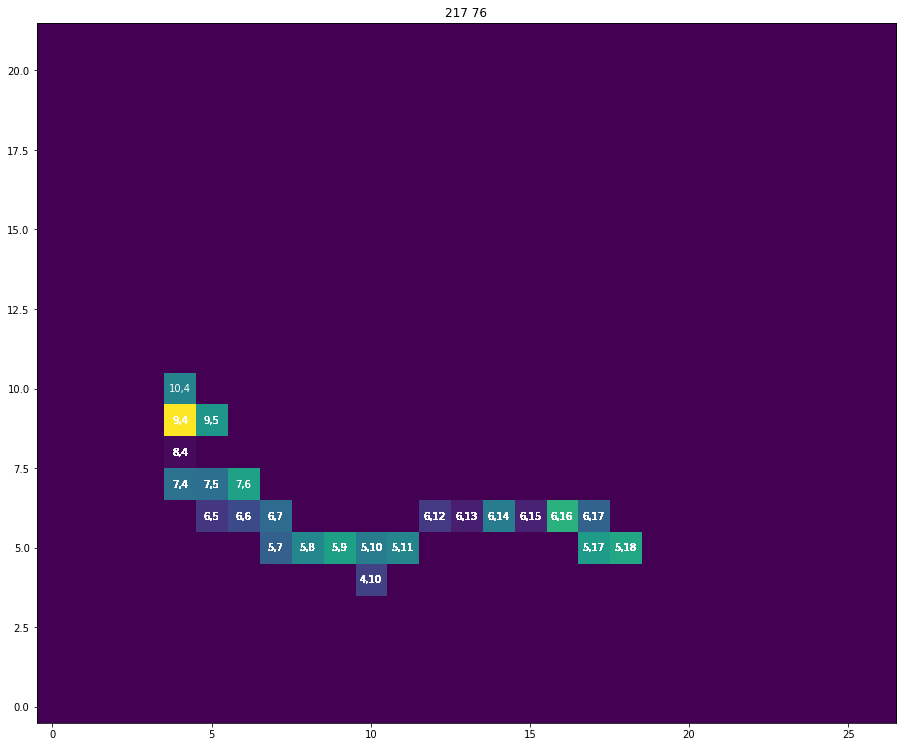

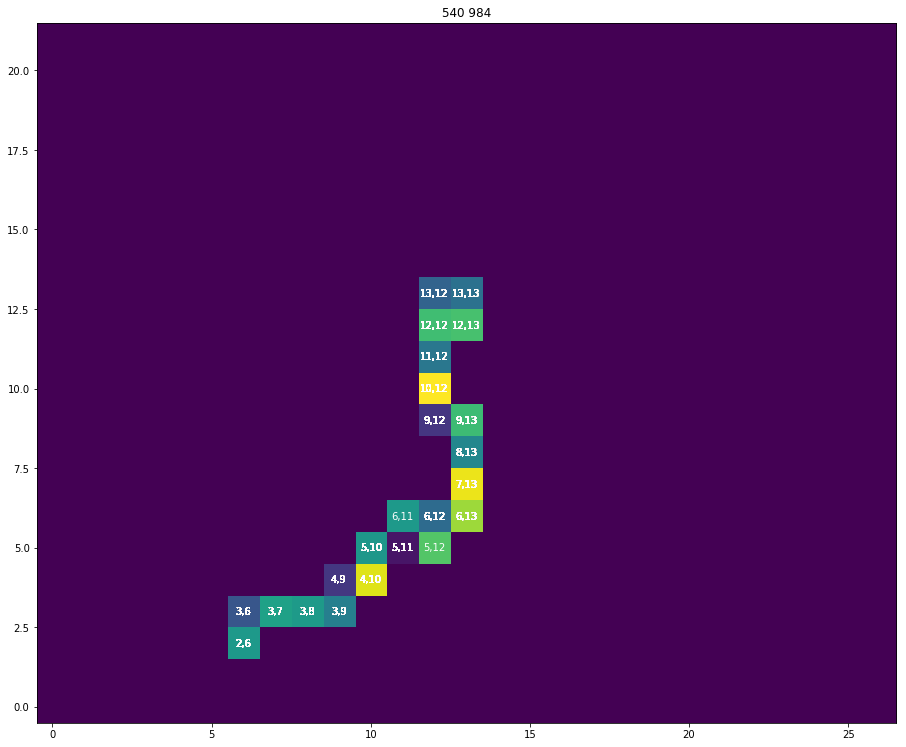

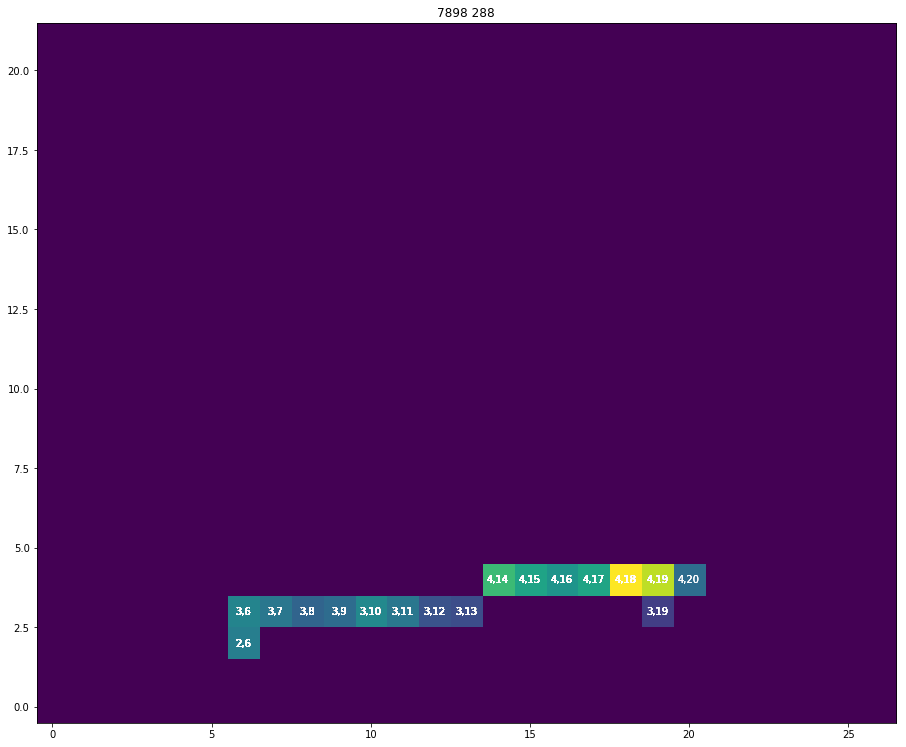

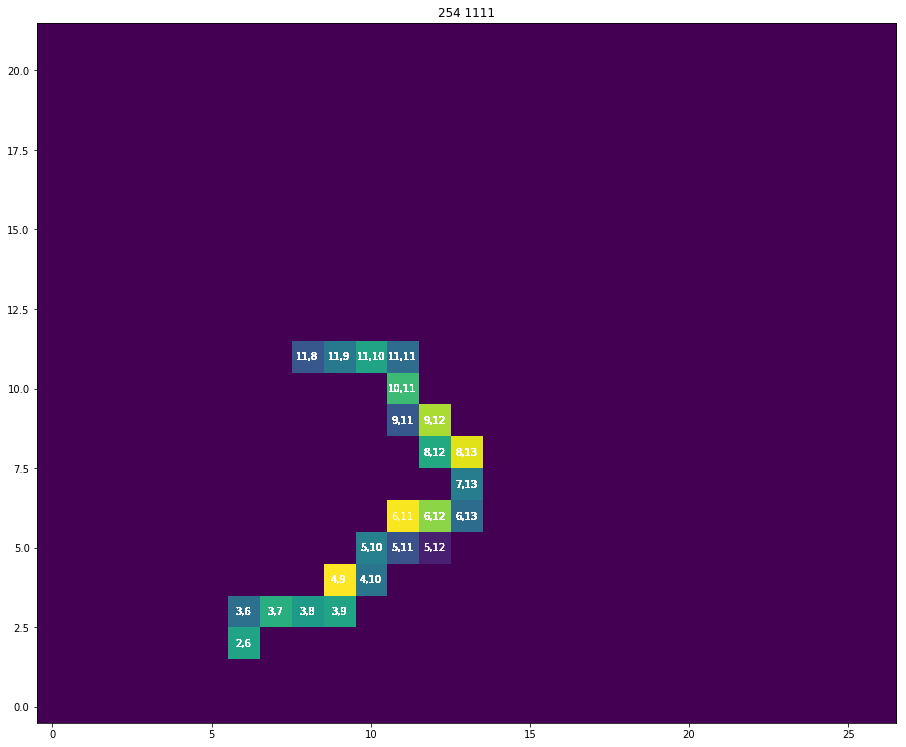

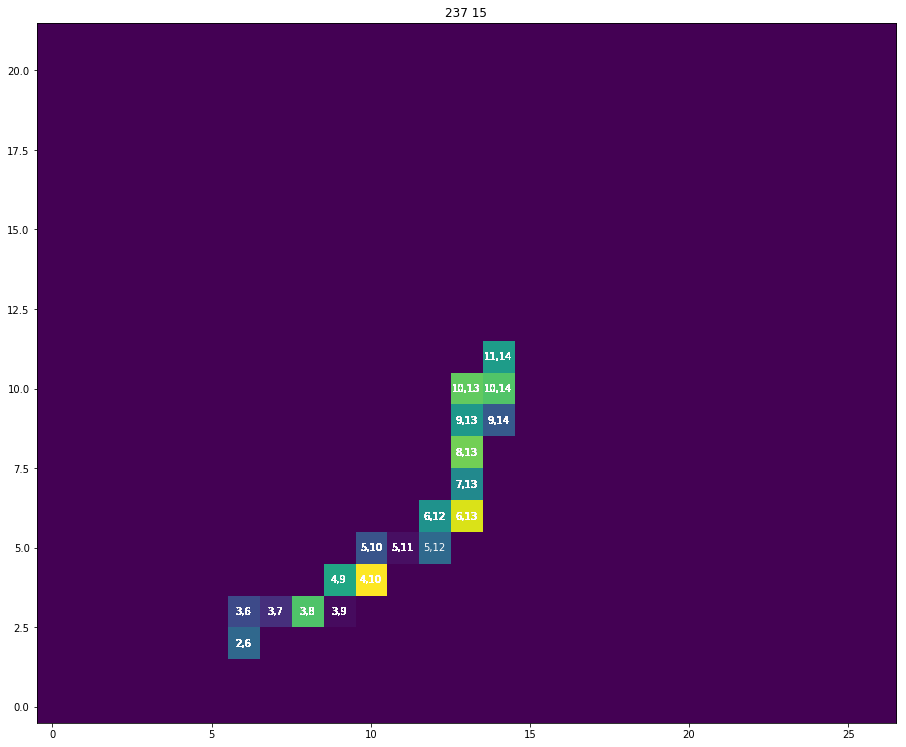

In [8]:
matplotlib.rcParams['figure.figsize'] = [15.4, 18.9]
unique_lines = data.line.unique()
for line in unique_lines[:5]:
    p = show_matrix(data.query('line == {0}'.format(line)))

Ahora lo agregamos a el dataset y guardamos los cambios.

In [9]:
positions, _ = get_matrix_positions(data)

In [10]:
data['matrix_position'] = positions

In [11]:
data.head(12)

,id,line,longitude,latitude,timestamp,next_longitude,next_latitude,next_timestamp,distance,time,speed,matrix_position
0,76,217,-56.222400,-34.855885,2018-10-02 14:38:53,-56.222717,-34.855766,2018-10-02 14:39:23,31.807877,0 days 00:00:30.000000000,1.060263,"[8, 4]"
1,76,217,-56.222717,-34.855766,2018-10-02 14:39:23,-56.222733,-34.855780,2018-10-02 14:39:53,2.134200,0 days 00:00:30.000000000,0.071140,"[8, 4]"
2,76,217,-56.222733,-34.855780,2018-10-02 14:39:53,-56.222916,-34.855682,2018-10-02 14:40:08,19.939152,0 days 00:00:15.000000000,1.329277,"[8, 4]"
3,76,217,-56.222916,-34.855682,2018-10-02 14:40:08,-56.222866,-34.855682,2018-10-02 14:40:23,4.562295,0 days 00:00:15.000000000,0.304153,"[8, 4]"
4,76,217,-56.222866,-34.855682,2018-10-02 14:40:23,-56.222850,-34.855667,2018-10-02 14:40:38,2.216614,0 days 00:00:15.000000000,0.147774,"[8, 4]"
5,76,217,-56.222850,-34.855667,2018-10-02 14:40:38,-56.222866,-34.855667,2018-10-02 14:40:53,1.459935,0 days 00:00:15.000000000,0.097329,"[8, 4]"
6,76,217,-56.222866,-34.855667,2018-10-02 14:40:53,-56.222935,-34.855650,2018-10-02 14:41:38,6.573623,0 days 00:00:45.000000000,0.146081,"[8, 4]"
7,76,217,-56.222935,-34.855650,2018-10-02 14:41:38,-56.222950,-34.855650,2018-10-02 14:41:53,1.368689,0 days 00:00:15.000000000,0.091246,"[8, 4]"
8,76,217,-56.222950,-34.855650,2018-10-02 14:41:53,-56.222935,-34.855750,2018-10-02 14:42:08,11.203411,0 days 00:00:15.000000000,0.746894,"[8, 4]"
9,76,217,-56.222935,-34.855750,2018-10-02 14:42:08,-56.222935,-34.855766,2018-10-02 14:42:23,1.779119,0 days 00:00:15.000000000,0.118608,"[8, 4]"


Como en Montevideo el transito se comporta diferente dependiendo de la hora del dia podemos ver entre que rangos tenemos las horas y evaluar la posiblidad de discretizar los rangos horarios para mantener esa informacion o descartarla en caso de que no aporte mucho.

In [14]:
max_time = data.timestamp.max()
min_time = data.timestamp.min()

print('Max time: {0}\nMin time: {1}'.format(max_time, min_time))

Max time: 2018-10-02 17:49:43
Min time: 2018-10-02 14:38:53


Vemos que se encuentran en un rango entre las 14:30hs ~ 17:50hs. No tenemos un rango lo suficientemente amplio como para separarlo en bins.

In [13]:
data.to_csv('../data/bus_data_stage_3.csv')

Ahora que tenemos datos como para modelar un problema, en la proxima sección vamos a comprobar estos datos buscando missing values y outliers en los datos generados.